# Fetal immune atlas - BBKNN Integration

In this notebook we perform integration of datasets from different organs

In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
from bbknn import bbknn
## For geosketch integration
from geosketch import gs, uniform, srs, kmeanspp
from scanorama import transform
from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
# from subprocess import Popen
# import sys
from time import time

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Load merged dataset 

In [3]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

Change barcodes for gut cells

In [5]:
def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

In [6]:
obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

In [7]:
merged_raw.obs_names = obs_names

### Dataset subsetting with Geometric sketching 
To speed up the integration from a large number of cells we will use the geometric sketching approach introduced by [Hie et al.(2019)](https://www.cell.com/cell-systems/fulltext/S2405-4712(19)30152-8). Briefly, this is a strategy to subset a large single-cell dataset by sampling not uniformly across the whole dataset, but sampling in a _plaid covering_ of the dataset, which approximates the geometry of the given single-cell data as a union of equal-sized boxes. As dimensions for plaid covering we use diffusion components and PCs.

In [6]:
## Load cell cycle genes
cwd = '/nfs/team205/ed6/data/Fetal_immune/Pan_fetal/JP_archive/18_Pan_fetal/scjp'
sys.path.append(cwd)

In [7]:
from scjp.genes import cc_genes

In [8]:
from geosketch import gs

def remove_geneset(adata,geneset):
    adata = adata[:,~adata.var_names.isin(list(geneset))].copy()
    return adata

def get_subset(idata, select, cc_genes=cc_genes, log=False,raw=True):
    if raw:
        adata = sc.AnnData(idata[select].raw.X)
        adata.var = idata.raw.var
    else:
        adata = sc.AnnData(idata[select].X)
        adata.var = idata.var
    adata.obs = idata.obs[select]
    adata.raw = adata.copy()
    #adata.X = scipy.sparse.csr_matrix(np.exp(adata.X.todense())-1)
    sc.pp.filter_genes_dispersion(adata,log=log)
    if log:
        sc.pp.log1p(adata)
    sc.pp.scale(adata,max_value=10)
    if len(cc_genes)>0:
        print('removing cc_genes...')
        adata = remove_geneset(adata,cc_genes)
    sc.pp.pca(adata,n_comps = np.min([50,adata.X.shape[0],adata.X.shape[1]]))
    return adata

def get_sketch(adata,key,folds=10,how='pd',min_num_per_key=500,start='filter',raw=True):
    '''
    geometric sketching based on diffusion map and pca
    - key: key for the batch information
    - folds: folds to subsample
    - min_num_per_key: minimun number to sample
    '''
    sketch_index = []
    for smp in set(adata.obs[key]):
        print(smp)
        c = adata.obs[key] == smp
        print('from:',sum(c))
        
        if start=='filter':
            sdata = get_subset(adata,c,raw=raw)
        else:        
            sdata = adata[c]
            sc.pp.filter_genes_dispersion(sdata)
            sc.pp.pca(sdata)
        
        if 'd' in how:
            sc.pp.neighbors(sdata)
            sc.tl.diffmap(sdata)

        N = np.max([np.int(np.sum(c)/folds),np.min([min_num_per_key,np.sum(c)])])
        print('to select:',N)
        if how =='pd':
            set1 = set(sdata.obs_names[gs(sdata.obsm['X_diffmap'],N,replace=False)])
            set2 = set(sdata.obs_names[gs(sdata.obsm['X_pca'][:,:50],N,replace=False)])
            sketch_index.extend(list(set1.union(set2)))
        elif how =='p':
            set2 = set(sdata.obs_names[gs(sdata.obsm['X_pca'][:,:50],N,replace=False)])
            sketch_index.extend(list(set2))
        elif how =='d':
            set1 = set(sdata.obs_names[gs(sdata.obsm['X_diffmap'][:,:20],N,replace=False)])
            sketch_index.extend(list(set1))
        else:
            raise SystemError
        print('length of sketch:',len(sketch_index))

    return(sketch_index)

In [12]:
sketch_index = get_sketch(merged_raw,'batch',folds=5, how='pd', raw=False, min_num_per_key=10000)

YS3GEX
from: 17799


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc

to select: 10000
length of sketch: 13227
SP3GEX
from: 51171


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 10234
length of sketch: 29686
KI3GEX
from: 22999


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 10000
length of sketch: 44560
SK3GEX
from: 75592


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 15118
length of sketch: 69164
LI5GEX
from: 68571


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 13714
length of sketch: 92308
GU3GEX
from: 64253


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 12850
length of sketch: 113300
LI3GEX
from: 152341


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 30468
length of sketch: 164970
TH5GEX
from: 54664


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 10932
length of sketch: 183315
BM3GEX
from: 40621


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 10000
length of sketch: 199238
KI5GEX
from: 4356


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


to select: 4356
length of sketch: 203594
SP5GEX
from: 85718


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 17143
length of sketch: 231860
BM5GEX
from: 61666


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 12333
length of sketch: 252423
TH3GEX
from: 54925


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 10985
length of sketch: 270496
TH(pharyn)3GEX
from: 4926


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


to select: 4926
length of sketch: 275422
YS5GEX
from: 41230


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 10000
length of sketch: 291191
SK5GEX
from: 112963


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


removing cc_genes...


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


to select: 22592
length of sketch: 328301


In [13]:
# sketch_index = [_rename_gut_cells(x) if 'cellranger' in x else x for x in sketch_index]

In [14]:
sketch_adata = merged_raw[sketch_index].copy()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
sketch_adata.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.sketch.h5ad')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'batch' as categorical
... storing 'bbk' as categorical


In [443]:
sketch_adata = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.sketch.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Add cell type labels

Made uniform in `notebooks/20201230_UniformCellLabels.ipynb`

In [444]:
annot_dir = '/home/jovyan/mount/gdrive/Pan_fetal/annotations/'
annot_df = pd.read_csv(annot_dir + "uniform_labels_full.csv", index_col=0)

In [445]:
### WARNING!! There are duplicated indices in the skin dataset, here I am solving the brute force way
annot_df.loc[annot_df.index[annot_df.index.duplicated()],'uniform_label']="NEUTROPHIL"
annot_df.loc[annot_df.index[annot_df.index.duplicated()],'cell.labels']="Neutrophile"

annot_df = annot_df.reset_index().drop_duplicates().set_index("index")


Fix names to make them uniform w dataset

In [446]:
annot_df.index = ["GEX".join(x.split("prime")) for x in annot_df.index]

In [447]:
def _translate_obs_names(x, organ):
    if organ in ["sp", 'bm']:
        if "FCA" in x:
            obs_name = x.split("_")[3]+ '-' +x.split("_")[5]
        else:
            obs_name = x
    elif organ in ["li", 'ys']:
        obs_name = x.split("_")[3]+'-'+x.split("_")[4]
    elif organ in ["sk"]:
        obs_name = x.split("-")[2]+'-'+x.split("-")[0]
    elif organ in ["gu"]:
        obs_name = "-".join(x.split("-")[:2]) + "_" + x.split("-")[2]
    else:
        obs_name = x
    return(obs_name)

In [448]:
# annot_df.index = annot_df["old_name"]

new_name = [_translate_obs_names(annot_df.index[i],annot_df.organ[i]) for i in range(annot_df.shape[0])]

In [449]:
annot_df["old_name"] = annot_df.index
annot_df.index = new_name

In [450]:
new_anno = pd.concat([annot_df[['uniform_label']], sketch_adata.obs], 1)

In [451]:
sketch_adata.obs = new_anno[~new_anno.Sample.isna()].loc[sketch_adata.obs_names]

### Define sketch

In [452]:
sketch_adata_bbk = sketch_adata[sketch_adata.obs.bbk.isin(bbk_counts[bbk_counts > 2000].index)]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [469]:
## Split by dataset (bbk column)
datasets_adatas = []
for i in sketch_adata_bbk.obs["batch"].unique():
    datasets_adatas.append(sketch_adata_bbk[sketch_adata_bbk.obs["batch"]==i])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [668]:
# def get_proportional_sketch(X, min_num_per_key=500, folds=5):
#     '''
#     geometric sketching proportional to total number of cells in dataset
#     '''
#     c = X.shape[0]
#     N = np.max([np.int(np.sum(c)/folds),np.min([min_num_per_key,np.sum(c)])])
#     idxs = sorted(set(gs(X, N, replace=False)))
#     return(idxs)

def preprocess4sketch(sdata, how="pd"):
    sc.pp.filter_genes_dispersion(sdata)
    sc.pp.scale(sdata,max_value=10)
    sdata = remove_geneset(sdata,cc_genes)
    if "p" in how:
        sc.pp.pca(sdata)
    if "d" in how:
        sc.pp.neighbors(sdata)
        sc.tl.diffmap(sdata)
    return sdata

def get_sketch_single(sdata,folds=10,how='pd',min_num_per_key=500):
    '''
    geometric sketching based on diffusion map and pca
    - folds: folds to subsample
    - min_num_per_key: minimun number to sample
    '''
    c = sdata.shape[0]
    print('from:',c)

    N = np.max([np.int(c/folds),np.min([min_num_per_key,c])])
    print('to select:',N)
    if how =='pd':
        set1 = set(sdata.obs_names[gs(sdata.obsm['X_diffmap'],N,replace=False)])
        set2 = set(sdata.obs_names[gs(sdata.obsm['X_pca'][:,:50],N,replace=False)])
        sketch_index = list(set1.union(set2))
    elif how =='p':
        set2 = set(sdata.obs_names[gs(sdata.obsm['X_pca'][:,:50],N,replace=False)])
        sketch_index = list(set2)
    elif how =='d':
        set1 = set(sdata.obs_names[gs(sdata.obsm['X_diffmap'][:,:20],N,replace=False)])
        sketch_index = list(set1)
    else:
        raise SystemError
    print('length of sketch:',len(sketch_index))
    return(sketch_index)

In [471]:
for i in range(len(datasets_adatas)):
    datasets_adatas[i] = preprocess4sketch(datasets_adatas[i])

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my

In [472]:


# Sketch each dataset.
sketch_idxs = [
    get_sketch_single(X, folds=10, min_num_per_key=10)
    for X in datasets_adatas
]

from: 13227
to select: 1322
length of sketch: 2335
from: 16459
to select: 1645
length of sketch: 2982
from: 14874
to select: 1487
length of sketch: 2705
from: 24604
to select: 2460
length of sketch: 4407
from: 23044
to select: 2304
length of sketch: 4189
from: 20949
to select: 2094
length of sketch: 3778
from: 51670
to select: 5167
length of sketch: 9330
from: 16628
to select: 1662
length of sketch: 2900
from: 15923
to select: 1592
length of sketch: 2886
from: 4356
to select: 435
length of sketch: 763
from: 28266
to select: 2826
length of sketch: 5110
from: 20563
to select: 2056
length of sketch: 3702
from: 18073
to select: 1807
length of sketch: 3237
from: 4926
to select: 492
length of sketch: 869
from: 15769
to select: 1576
length of sketch: 2878
from: 37110
to select: 3711
length of sketch: 6615


In [473]:
datasets_dimred = [X.obsm["X_pca"] for X in datasets_adatas]

In [475]:
datasets_sketch = [ X[idx].obsm["X_pca"] for X, idx in zip(datasets_adatas, sketch_idxs) ]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Integration on sketch dataset

In [477]:
sketch_idxs_all = np.concatenate([ X[idx].obs_names for X, idx in zip(datasets_adatas, sketch_idxs)])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [478]:
# sketch_adata_bbk_2 = sketch_adata[sketch_adata.obs.bbk.isin(bbk_counts[bbk_counts > 2000].index)]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [482]:
adata = sketch_adata_bbk[sketch_idxs_all].copy()
# smp_obs = random.sample(sketch_adata_bbk.obs_names.tolist(), 15000)
# adata = sketch_adata_bbk_2[smp_obs].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [484]:
adata = preprocess4sketch(adata)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [22]:
def is_cycling(adata,cc_genes=cc_genes,cut_off=0.4):
    X = np.mean(adata.X[:,adata.var_names.isin(cc_genes)],axis=1)
    plt.hist(X)
    adata.obs['Cycle_score'] = X
    adata.obs['isCycle'] = X>cut_off

Iterative BBKNN + ridge regression for batch integration

In [23]:
# batch regression methods

def regress_batch_v2(adata,batch_key,confounder_key):
    '''batch regression tool
    batch_key=list of observation categories to be regressed out
    confounder_key=list of observation categories to be kept
    returns ndata with corrected X'''

    from sklearn.linear_model import Ridge
    
    print('fitting linear model...')
    dummy = pd.get_dummies(adata.obs[batch_key+confounder_key],drop_first=False)
    X_exp = adata.X # scaled data
    if scipy.sparse.issparse(X_exp):
        X_exp = X_exp.todense()
    LR = Ridge(fit_intercept=False,alpha=1.0)
    LR.fit(dummy,X_exp)

    if len(batch_key)>1:
        batch_index = np.logical_or.reduce(np.vstack([dummy.columns.str.startswith(x) for x in batch_key]))
    else:
        batch_index = np.vstack([dummy.columns.str.startswith(x) for x in batch_key])[0]
    
    print('correcting batch...')
    dm = np.array(dummy)[:,batch_index]
    X_explained = dm.dot(LR.coef_[:,batch_index].T)
    X_remain = X_exp - X_explained
    ndata = sc.AnnData(X_remain)
    ndata.obs = adata.obs
    ndata.var = adata.var
    return ndata, X_explained

# def regress_iter(adata,batch_key,confounder_key,bbknn_key,scale=True, approx = True,n_pcs=50):
#     if scale == True:
#         print('scaling data...')
#         sc.pp.scale(adata,max_value=10)
#     ndata, X_explained = regress_batch_v2(adata,batch_key=batch_key,confounder_key=confounder_key)
#     print('running pca...')
#     sc.pp.pca(ndata)
#     print('running bbknn...')
#     bbknn(ndata, batch_key = bbknn_key,n_pcs=n_pcs, approx=approx)
#     return ndata #, X_explained


In [492]:
ndata, X_explained = regress_batch_v2(adata, batch_key=['method','donor'],confounder_key=['uniform_label'])
sc.pp.pca(ndata)

fitting linear model...
correcting batch...


In [493]:
bbknn(ndata, batch_key = "bbk", n_pcs=30, approx=True)
sc.tl.umap(ndata)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'uniform_label' as categorical


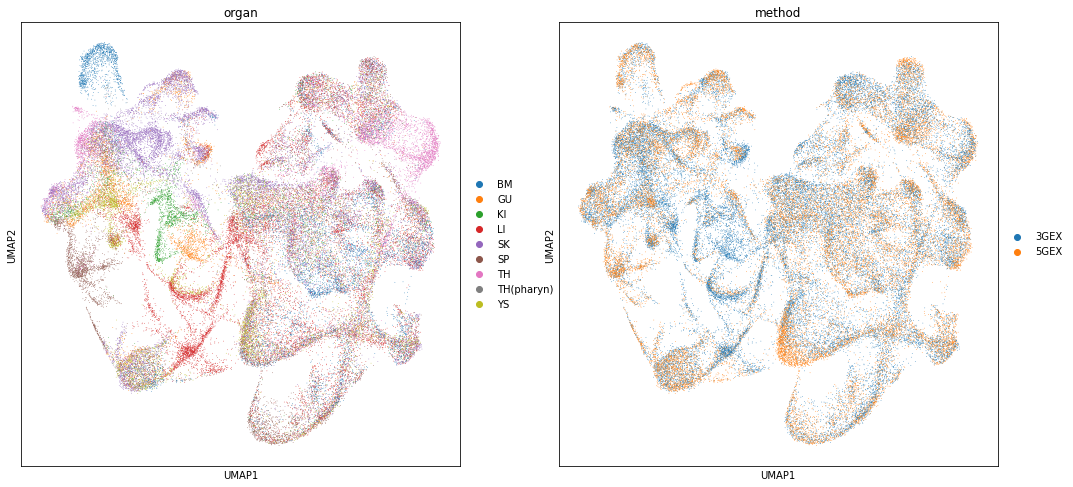

In [494]:
sc.pl.umap(ndata, color=["organ", "method"])

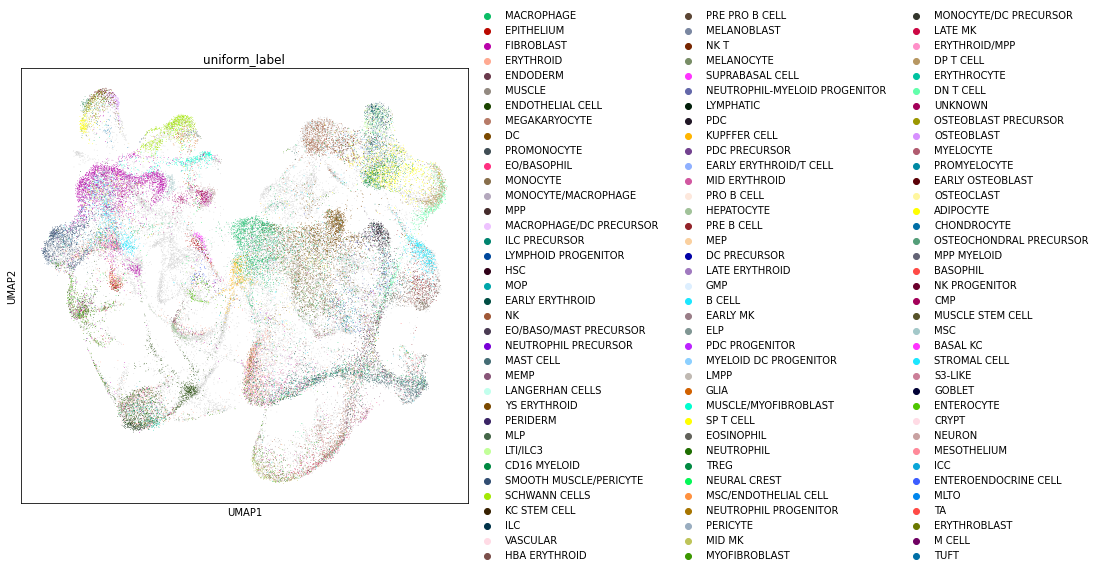

In [495]:
sc.pl.umap(ndata, color="uniform_label", palette=sc.plotting.palettes.default_102,
          groups=adata_int_orig.obs[~(adata_int_orig.obs["uniform_label"] == 'nan')].uniform_label.unique())

In [522]:
smp_obs = random.sample(sketch_adata_bbk.obs_names.tolist(), len(sketch_idxs_all))
adata2 = sketch_adata_bbk[smp_obs].copy()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [523]:
adata2 = preprocess4sketch(adata2)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [497]:
# adata = anndata.concat([ X[idx] for X, idx in zip(datasets_adatas, sketch_idxs)])

In [525]:
ndata2, X_explained = regress_batch_v2(adata2, batch_key=['method','donor'],confounder_key=['uniform_label'])
sc.pp.pca(ndata2)

fitting linear model...
correcting batch...


In [526]:
bbknn(ndata2, batch_key = "bbk", n_pcs=30, approx=True)
sc.tl.umap(ndata2)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'uniform_label' as categorical


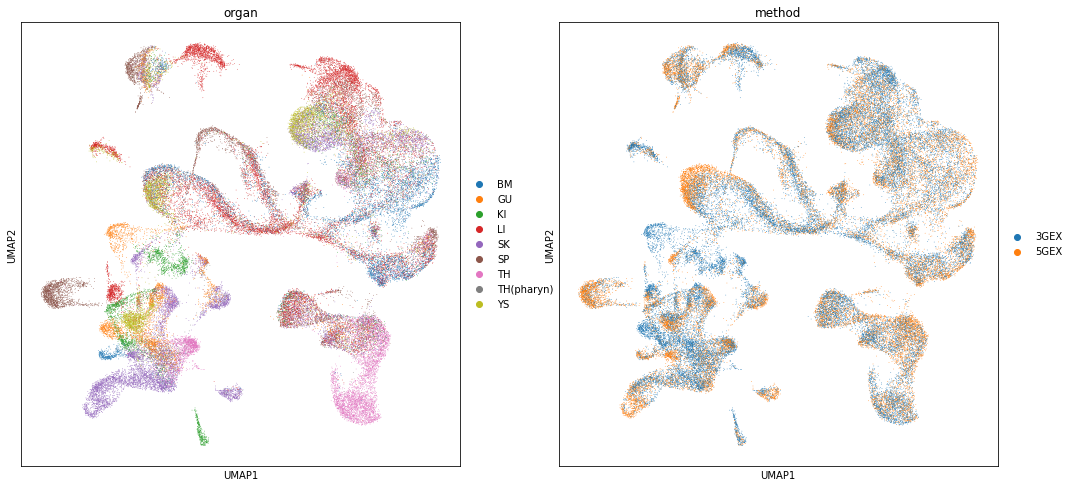

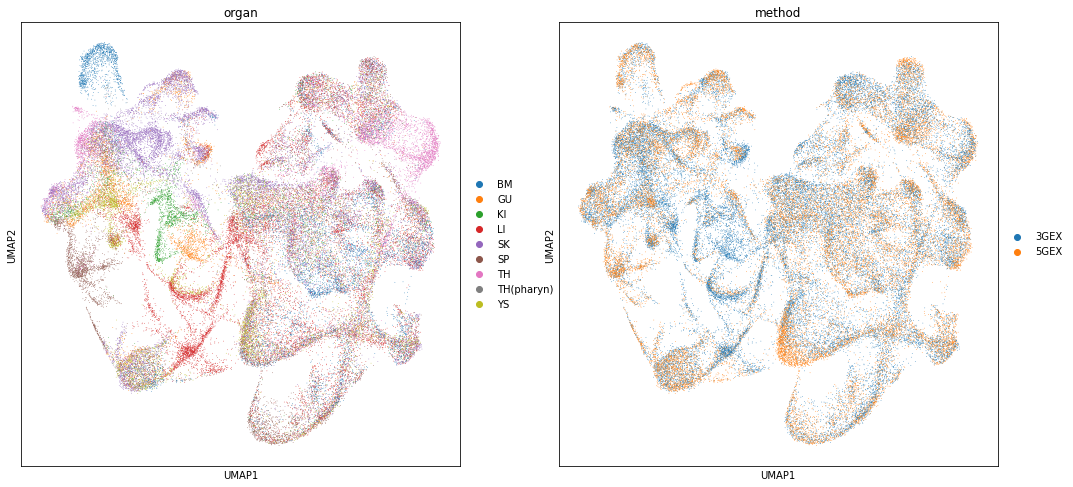

In [527]:
sc.pl.umap(ndata2, color=["organ", "method"])
sc.pl.umap(ndata, color=["organ", "method"])

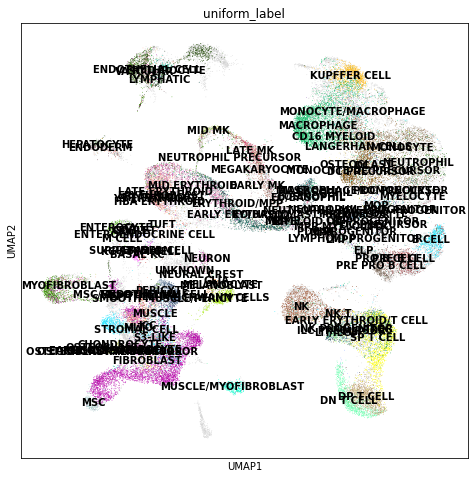

In [530]:
sc.pl.umap(ndata2, color="uniform_label", palette=sc.plotting.palettes.default_102,
           legend_loc="on data",
          groups=adata_int_orig.obs[~(adata_int_orig.obs["uniform_label"] == 'nan')].uniform_label.unique())

### Projection of full data

Source code from [`geosketch/bin/integration.py`](https://github.com/brianhie/geosketch/blob/master/bin/integration.py)

In [32]:


# from utils import log, mkdir_p

# def integrate_sketch(datasets_dimred, integration_fn, integration_fn_args={},
#                      sampling_type='geosketch', N=10000):

#     if sampling_type == 'geosketch':
#         from geosketch import gs
#         sampling_fn = gs
#     else:
#         from geosketch import uniform
#         sampling_fn = uniform

#     # Sketch each dataset.

#     sketch_idxs = [
#         sorted(set(sampling_fn(X, N, replace=False)))
#         for X in datasets_dimred
#     ]
#     datasets_sketch = [ X[idx] for X, idx in zip(datasets_dimred, sketch_idxs) ]

#     # Integrate the dataset sketches.

#     datasets_int = integration_fn(datasets_sketch[:], **integration_fn_args)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


ImportError: attempted relative import with no known parent package

In [428]:
datasets_sketch = [ X[idx] for X, idx in zip(datasets_dimred, sketch_idxs) ]

Integration on sketch dataset

In [429]:
sketch_idxs_all = np.concatenate([ X[idx].obs_names for X, idx in zip(datasets_adatas, sketch_idxs)])

In [414]:
sketch_adata_bbk_2 = sketch_adata[sketch_adata.obs.bbk.isin(bbk_counts[bbk_counts > 2000].index)]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Project bigger dataset

In [556]:
datasets_int = []
for i in sketch_adata_bbk.obs["batch"].unique():
    datasets_int.append(ndata2[ndata2.obs["batch"]==i].obsm["X_pca"])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [557]:
## Split sketch indexes by bbk
# sketch_adata[smp_obs].obs["bbk"]

sketch_idxs = []
for i in sketch_adata_bbk.obs["batch"].unique():
    sketch_idxs.append(ndata2[ndata2.obs["batch"]==i].obs_names)

In [558]:
datasets_sketch = [ X[idx].obsm["X_pca"] for X, idx in zip(datasets_adatas, sketch_idxs)]

In [559]:
# Apply integrated coordinates back to full data.
labels = []
curr_label = 0
for i, a in enumerate(datasets_sketch):
    labels += list(np.zeros(a.shape[0]) + curr_label)
    curr_label += 1
labels = np.array(labels, dtype=int)

In [ ]:
adata_int = anndata.concat(datasets_adatas)

In [669]:
sketch_adata_bbk_pp = preprocess4sketch(sketch_adata_bbk, how="p")

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [670]:
sketch_adata_bbk_pp

AnnData object with n_obs × n_vars = 326441 × 3238
    obs: 'uniform_label', 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'sort', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [694]:
## All in one go
X_int = ndata2.obsm["X_pca"]
X_dimred = sketch_adata_bbk_pp.obsm["X_pca"]
X_sketch = sketch_adata_bbk_pp[ndata2.obs_names].obsm["X_pca"]

In [695]:
neigh = NearestNeighbors(n_neighbors=10).fit(X_dimred)
_, neigh_idx = neigh.kneighbors(X_sketch)

In [698]:
ds_idxs, ref_idxs = [], []
for ref_idx in range(neigh_idx.shape[0]):
    for k_idx in range(neigh_idx.shape[1]):
        ds_idxs.append(neigh_idx[ref_idx, k_idx])
        ref_idxs.append(ref_idx)

bias = transform(X_dimred, X_int, ds_idxs, ref_idxs, 15, batch_size=1000)

dataset_int = X_dimred + bias

In [701]:
sum(bias.sum(1) > 0)

155323

In [560]:
## Each batch separately
for i, (X_dimred, X_sketch) in enumerate(zip(datasets_dimred, datasets_sketch)):
    X_int = datasets_int[i]

    neigh = NearestNeighbors(n_neighbors=10).fit(X_dimred)
    _, neigh_idx = neigh.kneighbors(X_sketch)

    ds_idxs, ref_idxs = [], []
    for ref_idx in range(neigh_idx.shape[0]):
        for k_idx in range(neigh_idx.shape[1]):
            ds_idxs.append(neigh_idx[ref_idx, k_idx])
            ref_idxs.append(ref_idx)

    bias = transform(X_dimred, X_int, ds_idxs, ref_idxs, 15, batch_size=1000)

    datasets_int[i] = X_dimred + bias


In [612]:
import sklearn.preprocessing
datasets_int = [sklearn.preprocessing.normalize(X,axis=1) for X in datasets_int]

In [614]:
# for i in range(len(datasets_int)):
#     datasets_adatas[i].obsm["X_ridge"] = datasets_int[i]

# [X.var_names_make_unique() for X in datasets_adatas]

In [648]:
adata_int = anndata.concat(datasets_adatas)

In [702]:
sketch_adata_bbk_pp.obsm["X_pca"] = dataset_int
sketch_adata_bbk_pp.obsm["X_pca_old"] = X_dimred

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


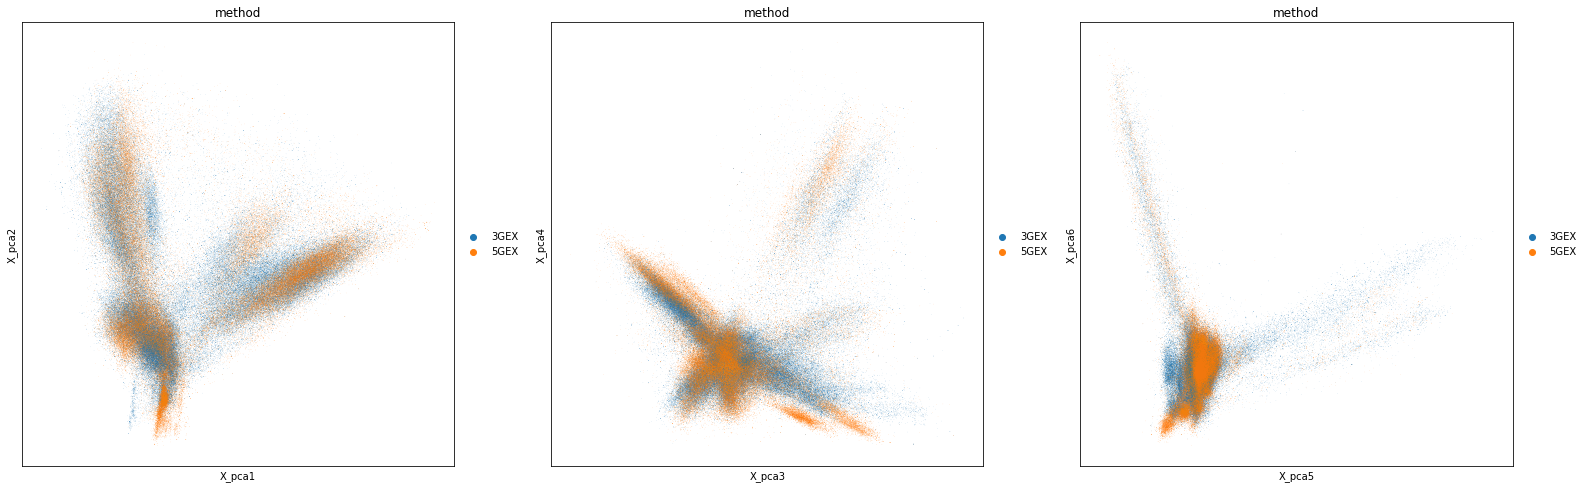

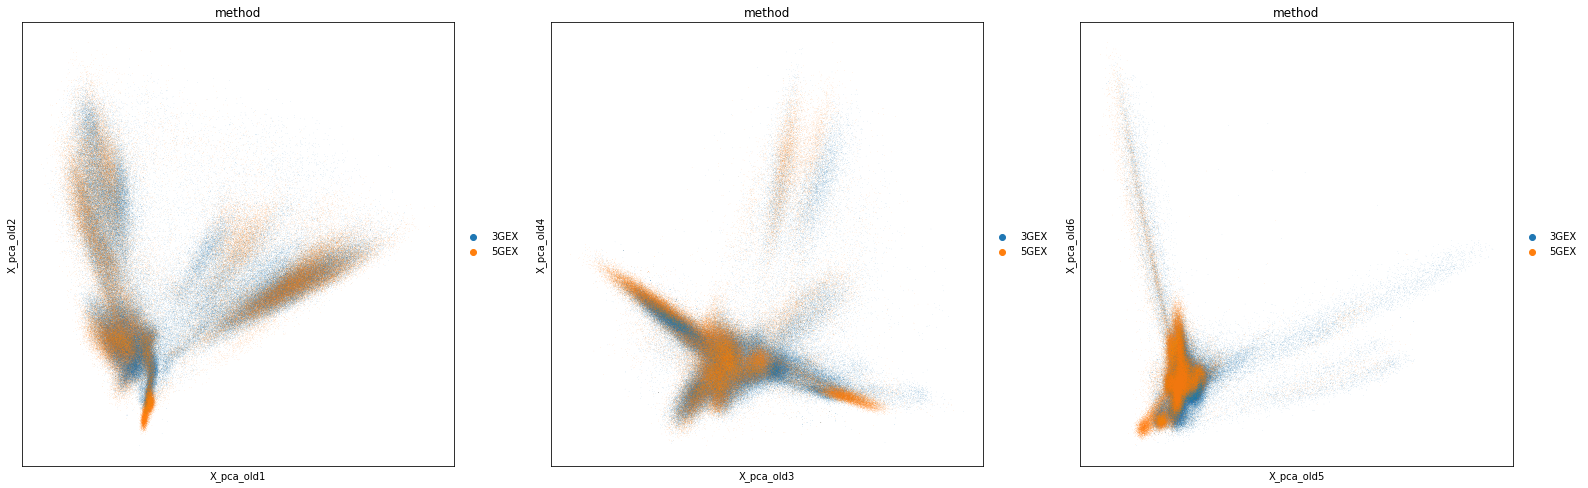

In [703]:
sc.pl.embedding(sketch_adata_bbk_pp, "X_pca", color="method", components=["1,2", '3,4', '5,6'])
sc.pl.embedding(sketch_adata_bbk_pp, "X_pca_old", color="method", components=["1,2", '3,4', '5,6'])

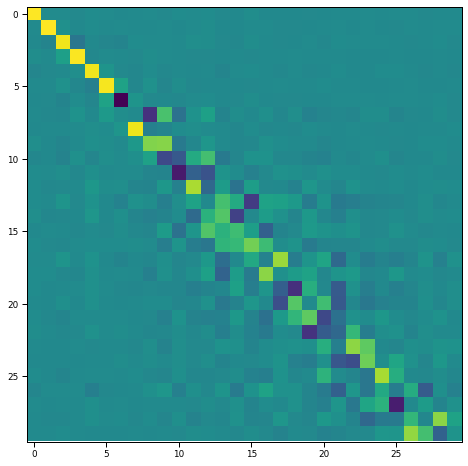

In [762]:
plt.imshow(np.corrcoef(sketch_adata_bbk_pp.obsm['X_pca'][:,0:30].T, sketch_adata_bbk_pp.obsm['X_pca_old'][:,0:30].T)[30:,:30])

Run BBKNN

In [619]:
# adata_int.obsm["X_pca"] = adata_int.obsm["X_ridge"]

In [721]:
from datetime import datetime
start=datetime.now()

bbknn(sketch_adata_bbk_pp, batch_key = "bbk", n_pcs=30, approx=True)
print(datetime.now()-start)

0:05:04.261738


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [722]:
sc.tl.umap(sketch_adata_bbk_pp)

In [758]:
sketch_adata_bbk_pp

AnnData object with n_obs × n_vars = 326441 × 3238
    obs: 'uniform_label', 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'sort', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk', 'is_corrected'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'method_colors', 'neighbors', 'umap', 'organ_colors', 'bbk_colors', 'uniform_label_colors', 'predicted_doublets_colors'
    obsm: 'X_pca', 'X_pca_old', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

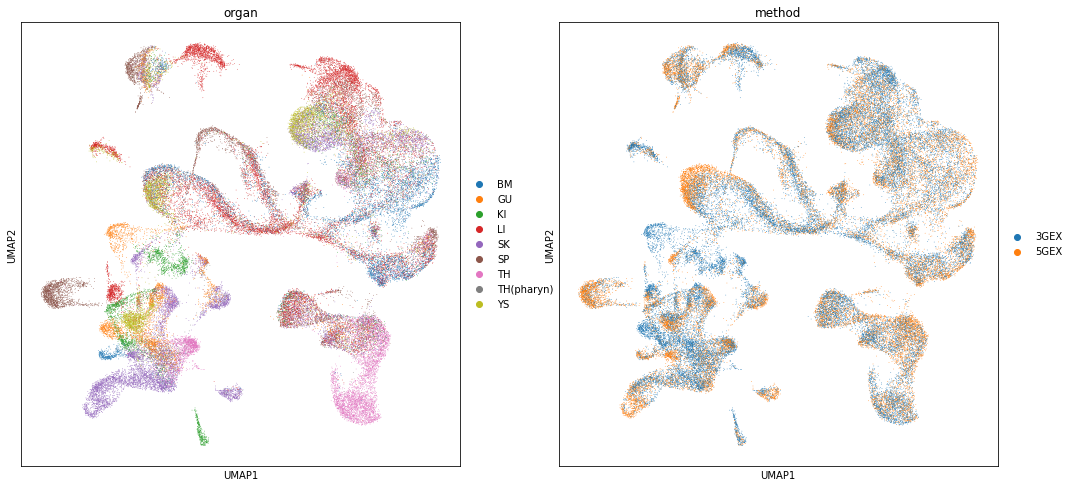

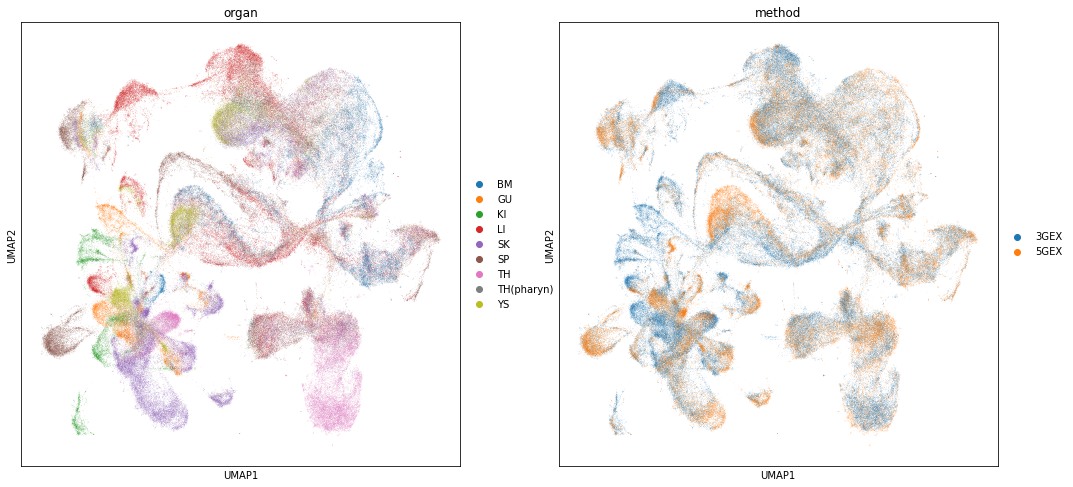

In [738]:
plt.rcParams["figure.figsize"] = [8,8]
sc.pl.umap(ndata2, color=["organ", "method"])
sc.pl.umap(sketch_adata_bbk_pp, color=["organ", "method"])

Trying to set attribute `.uns` of view, copying.


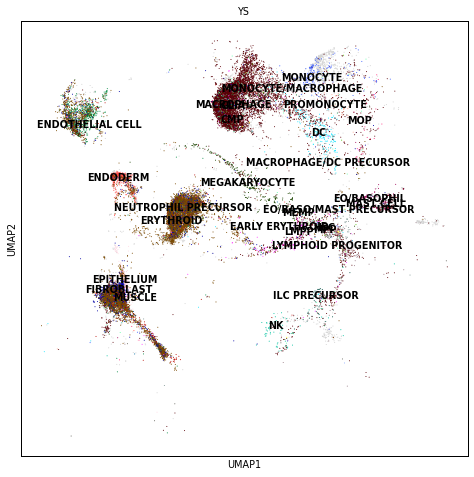

Trying to set attribute `.uns` of view, copying.


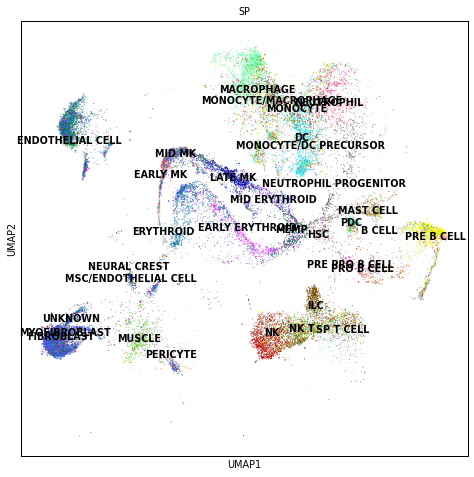

Trying to set attribute `.uns` of view, copying.


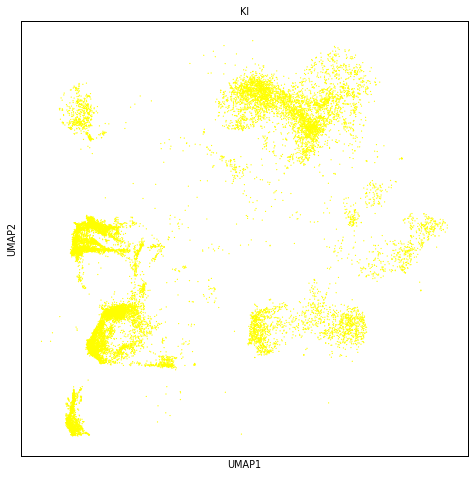

Trying to set attribute `.uns` of view, copying.


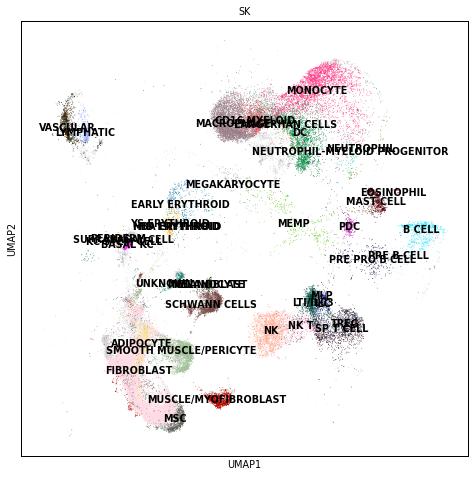

Trying to set attribute `.uns` of view, copying.


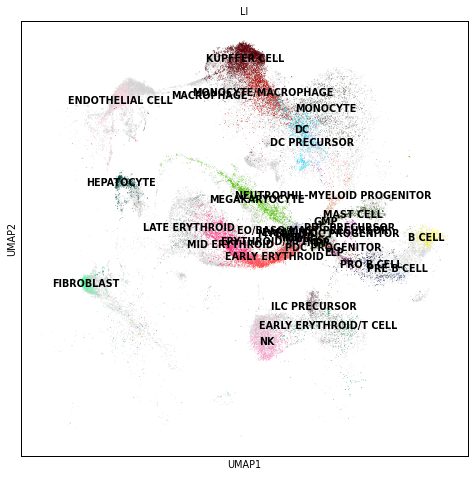

Trying to set attribute `.uns` of view, copying.


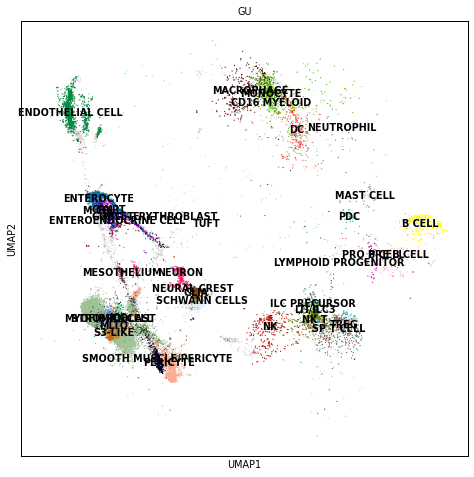

Trying to set attribute `.uns` of view, copying.


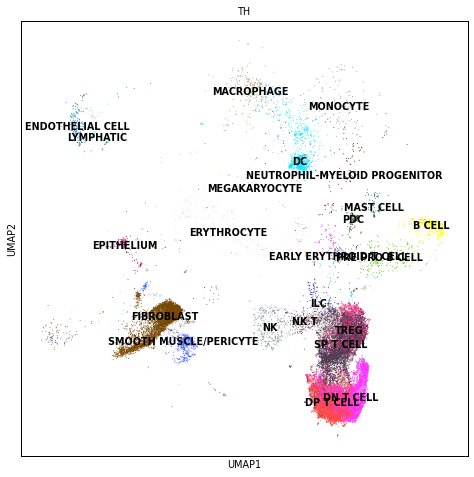

Trying to set attribute `.uns` of view, copying.


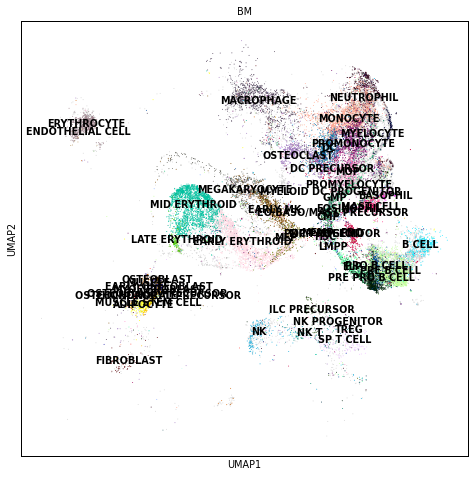

Trying to set attribute `.uns` of view, copying.


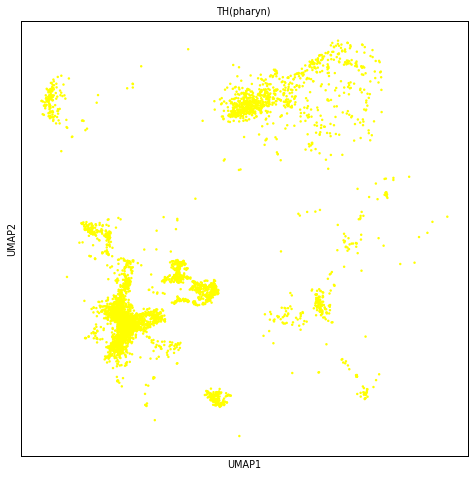

In [756]:
i=1
for org in sketch_adata_bbk_pp.obs['organ'].unique():
    subset_organ_adata = sketch_adata_bbk_pp[sketch_adata_bbk_pp.obs['organ']==org]
    sc.pl.umap(subset_organ_adata, color="uniform_label", palette=sc.plotting.palettes.default_102,
               legend_loc="on data",
               groups=subset_organ_adata[subset_organ_adata.obs["uniform_label"] != "nan"].obs["uniform_label"].unique(),
               title=org
              )
    i += 1

In [728]:
delta = sketch_adata_bbk_pp.obsm["X_pca_old"] - sketch_adata_bbk_pp.obsm["X_pca"]

In [729]:
sketch_adata_bbk_pp.obs['is_corrected'] = delta.sum(1)

In [734]:
sketch_adata_bbk_pp.obs.columns

Index(['uniform_label', 'Sample', 'n_counts', 'n_genes', 'donor', 'organ',
       'sort', 'method', 'file', 'mito', 'doublet_scores',
       'predicted_doublets', 'name', 'batch', 'bbk', 'is_corrected'],
      dtype='object')

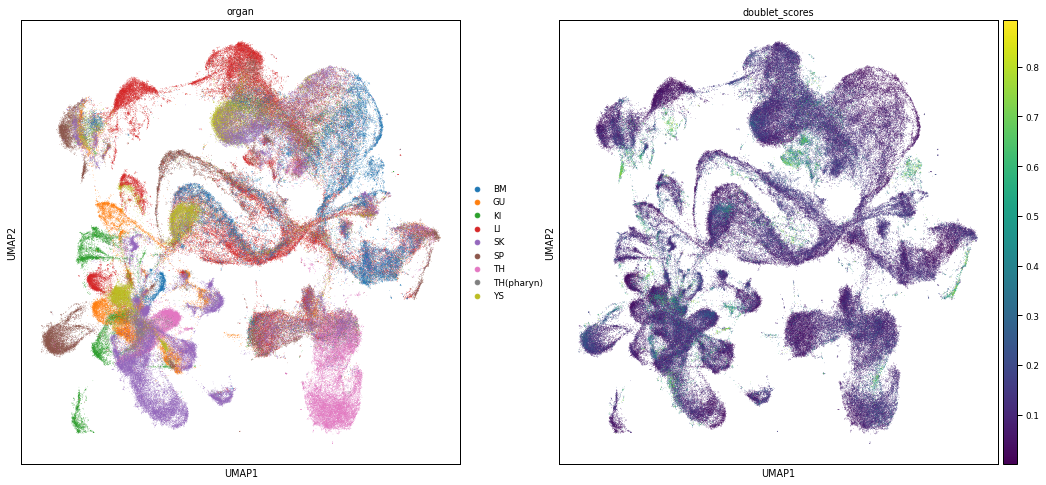

In [760]:
sc.pl.umap(sketch_adata_bbk_pp, color=["organ", 'doublet_scores'], size=1)

In [266]:
from datetime import datetime
start=datetime.now()

bbknn(adata_int_orig, batch_key = "bbk", n_pcs=30, approx=True)
print(datetime.now()-start)

0:04:41.489332


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [267]:
sc.tl.umap(adata_int_orig)

In [761]:
sc.pl.umap(adata_int_orig, color=["organ", "method"])

... storing 'uniform_label' as categorical
... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'sort' as categorical
... storing 'method' as categorical
... storing 'file' as categorical
... storing 'name' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical


KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: ['X_pca', 'X_diffmap', 'X_ridge']."

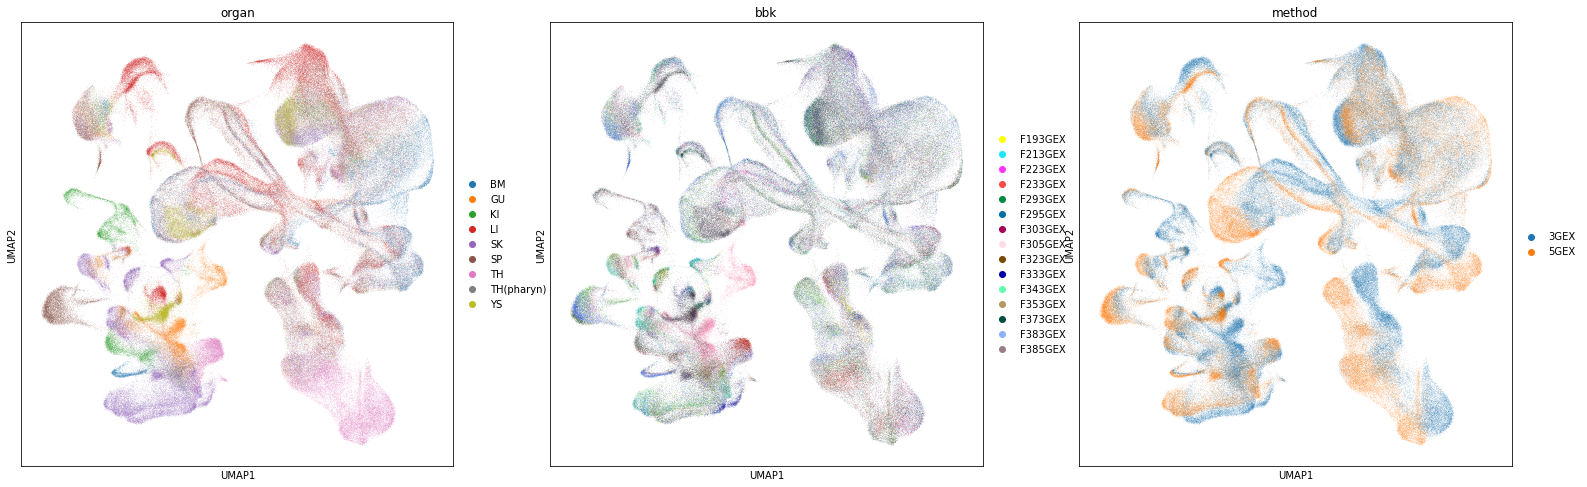

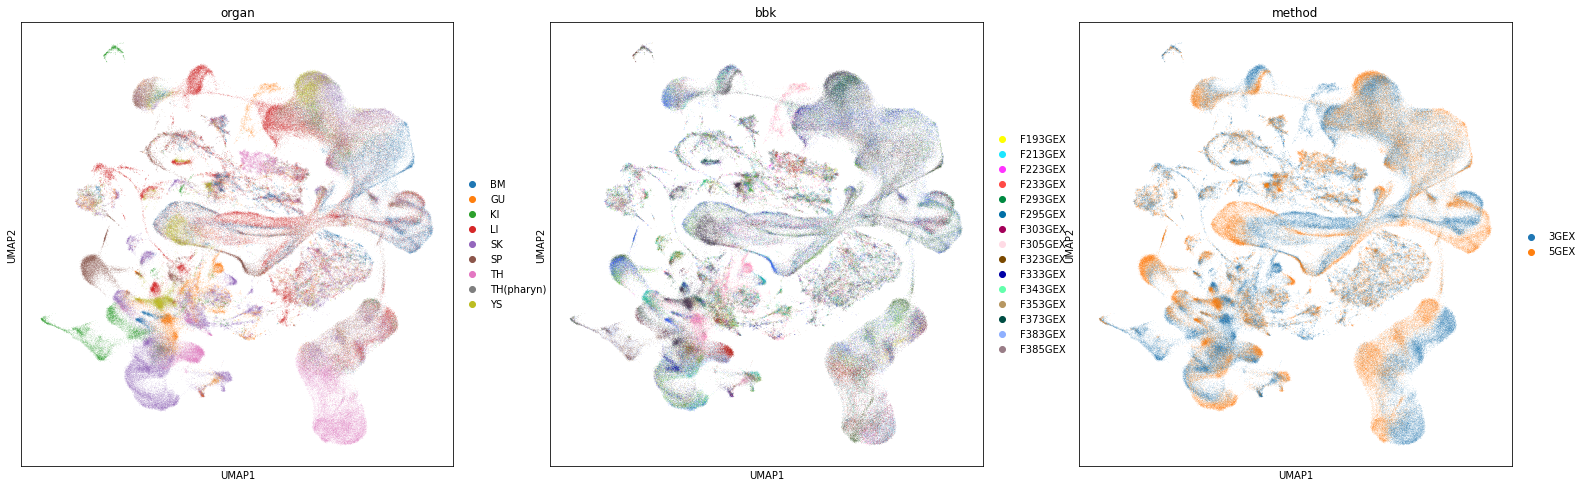

In [278]:
sc.pl.umap(adata_int_orig, color=["organ", "bbk", "method"])
sc.pl.umap(adata_int, color=["organ", "bbk", "method"])

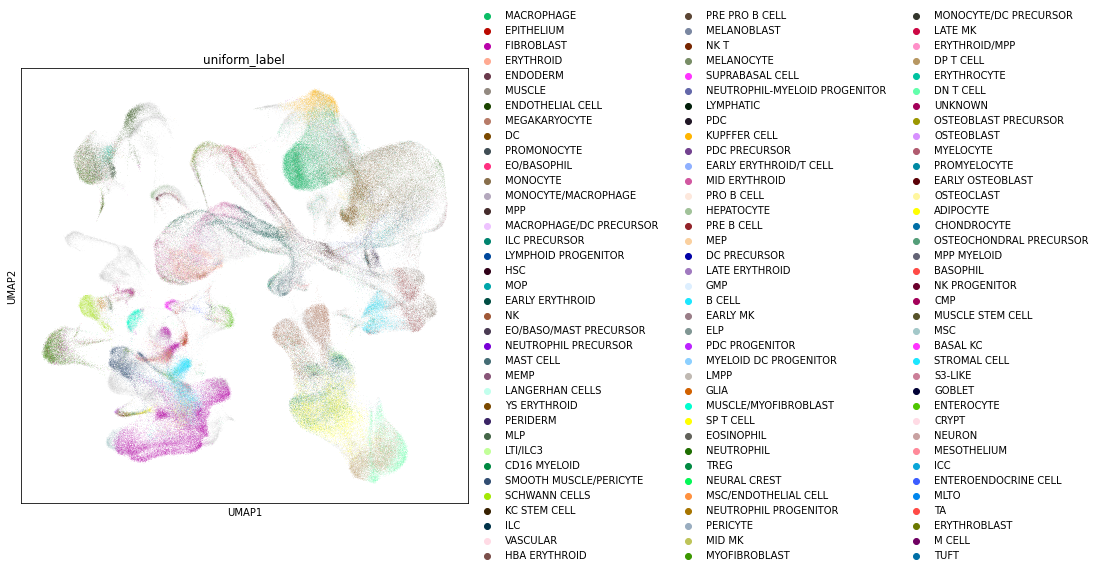

In [277]:
sc.pl.umap(adata_int_orig, color="uniform_label", palette=sc.plotting.palettes.default_102,
          groups=adata_int_orig.obs[~(adata_int_orig.obs["uniform_label"] == 'nan')].uniform_label.unique())